# LocusRegression Simulation Studies

This tutorial covers how to construct synthetic datasets, then train and evaluate LocusRegression models using those datasets. First, some imports: 

In [1]:
from locusregression.simulation import SimulatedCorpus, signature_cosine_distance, coef_l1_distance
from locusregression import LocusRegressor, tune_model

import numpy as np
import pandas as pd
import seaborn as sns

### Transition matrix

To simulate some data according to the generative model proposed by LocusRegression, we first need to define ground-truth genomic states for each locus in a hypothetical genome. We assign states by sampling a chain from a predefined Markov transition matrix. The transition matrix should be of size $(N_{states}, N_{states})$, and have rowsums of 1.

In [2]:
transition_matrix = np.array([
    [0.99, 0.005, 0.005],
    [0.0, 0.97, 0.03],
    [0.015, 0.015, 0.97]
])

Each of these states will correspond with changes to some simluated genomic correlate. Next we define the distribution of each correlate. Correlates are simulated using the model:

$X_{s,\ell} \sim \textrm{Normal}(\mu \cdot \delta({\textrm{state}(\ell) - s)}, \sigma^2)$

where the correlate associated with state $s$ is centered at $\mu$ for loci in that state, and $0$ otherwise. These correlates are stardardized before modeling. We provide a matrix of $\mu$'s and $\sigma$'s, each with shape $(N_{states})$.

In [3]:
signal_means = np.array([1.,1.,1.])
signal_stds = np.array([0.3, 0.25, 0.5])

### Trinucleotide differences

To finish setting up the properties of each genomic state, we define state-specific priors over the trinucleotide content of loci in that state. The trinucleotide content of each locus is subsequently sampled from a Dirichlet distribution with the corresponding prior. The priors matrix must be of shape $(N_{states}, 32)$. Here, I provide uniform priors for each state with varying degrees of noise/sparsity:

In [4]:
trinuc_priors = np.array([
    np.ones(32) * 5.,
    np.ones(32) * 20,
    np.ones(32) * 10,
])

To see which trinucleotides each column of this matrix corresponds with:

In [5]:
from locusregression.corpus.featurization import CONTEXTS

CONTEXTS[:5]

['ACA', 'ACC', 'ACG', 'ACT', 'CCA']

### $\beta$ matrix

Lastly, we need to relate those states and correlates to processes. For this, we define a $\beta$ matrix of size $(N_{processes}, N_{states})$, which relates how each process associates with genomic correlates:

In [6]:
beta_matrix = np.array([
    [1,-0.5,0],
    [-0.5,1,-0.5],
    [-0.5,-0.5,1],
    [1,-1,1],
    [0.,1.,1],
])

### Generating a simulated dataset

Now, we can use these generative parameters to construct a dataset. We provide the structured information outline above, along with parameters for:

* `n_cells` : the number of samples (called "cells" here in homage to ssDNA-seq)
* `log_mean_mutations`, `log_std_mutations`: parameters of the $\mathrm{LogNormal}$ distribution from which the number of mutations per cells are drawn
* `pi_prior` : prior for the dirichlet distribution from which compositions over processes are drawn for each cell
* `n_loci` : the number of genomic bins. 10Kb bins over the entire genome gives ~250K regions after filtering repetitive elements, centromeres, etc.
* `seed` : reproducably produces the same simulated dataset

And finally, we associate each process with a known signature from the COSMIC catalogue:

In [8]:
corpus, parameters = SimulatedCorpus.create(
    state_transition_matrix = transition_matrix,
    beta_matrix = beta_matrix,
    trinucleotide_priors = trinuc_priors,
    signal_means= signal_means,
    n_cells = 100,
    log_mean_mutations = 6,
    log_std_mutations = 0.5, 
    pi_prior = 1,
    n_loci = 250000,
    seed = 10,
    cosmic_sigs=['SBS1','SBS93','SBS3','SBS5','SBS2'],
)

Generating samples: 100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


The simulation method outputs the same "corpus" object which is used for real data, so we can treat real and simulated data exactly the same. Additionally, the simulation outputs `parameters`, which are the ground truth attributes of the dataset which governed the generative process.

In [9]:
parameters.keys()

dict_keys(['states', 'compositions', 'beta', 'signatures'])

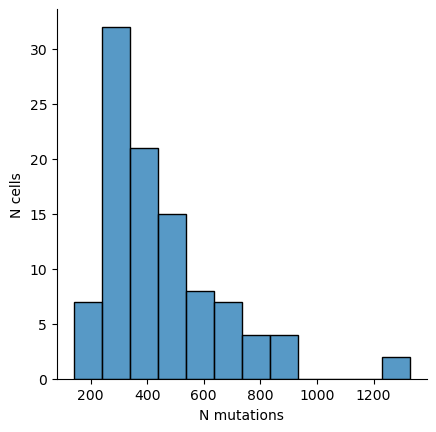

In [10]:
ax = sns.histplot([sum(sample['count']) for sample in corpus])
ax.set_aspect(1.0/ax.get_data_ratio())
ax.set(xlabel = 'N mutations', ylabel = 'N cells')
sns.despine()

## Modeling the dataset

You can either tune a model (most realistic), or just provide the number of topics and get started.

In [11]:
results = tune_model(corpus, 
                     min_components = 2, 
                     max_components = 10,  
                     n_jobs=5, 
                     factor=4 # higher factor, faster tuning
                    )

Running HyperBand with 5 jobs.
Bracket 1: Evaluating 10 models
Bracket 2: Evaluating 24 models
Bracket 3: Evaluating 24 models


Evaluating model configurations:  72%|██████████████████▌       | 2265/3165 [08:03<02:30,  5.97it/s]/Users/alynch/projects/signatures/locusregression/model/model.py:238: RuntimeWarning: overflow encountered in exp
  (window_size * np.exp(locus_logmu + 1/2*np.square(locus_logstd)) ).sum(axis = -1, keepdims = True)
/Users/alynch/projects/signatures/locusregression/model/model.py:318: RuntimeWarning: divide by zero encountered in log
  entropy_sstats = -np.sum(weighted_phi * np.where(phi_matrix > 0, np.log(phi_matrix), 0.))
Evaluating model configurations: 100%|██████████████████████████| 3165/3165 [09:14<00:00,  5.71it/s]


Inspect tuning results:

In [12]:
data = pd.DataFrame(results)
data['log_resources'] = np.log(data.resources)

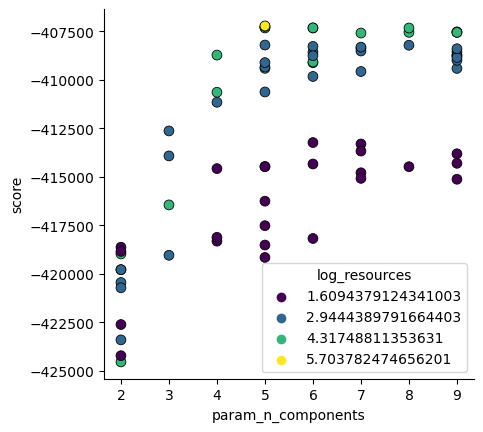

In [13]:
ax = sns.scatterplot(
    data = data,
    x = 'param_n_components',
    y = 'score',
    hue = 'log_resources',
    palette = 'viridis',
    edgecolor = 'black',
    s = 50,
)
ax.set_aspect(1.0/ax.get_data_ratio())
sns.despine()

In [14]:
data.dropna().sort_values('score').tail(1)

,bracket,param_n_components,param_locus_subsample,param_seed,resources,score,log_resources
73,1,5,0.125,76916696,300,-407230.812446,5.703782


Find parameters of the best model, which had 5 components and a seed of 76916696:

In [15]:
model = LocusRegressor(n_components=5, seed = 76916696).fit(corpus)

For testing purposes, you can probably skip the rigorous tuning step, and just put tight bounds around the appropriate number of processes to try out models with different seeds. The effect of the seed is very small, *unless* the model suffers "mode collapse", when early in training one of the components receives too little weight and is never used.

# Evaluation

I have some crude metrics implemented for evaluating the solution against the generative parameters. `coef_l1_distance` evaluates the mean $\mathrm{L1}$ distance between the the model's inferred $\beta$'s and the closest match with amongst the ground truth $\beta$'s. 

In [16]:
model.calc_signature_sstats(corpus) # reweights signatures by trincleotide frequencies 

In [17]:
coef_l1_distance(model, parameters)

0.0544037532992661

This model is very close to perfect. Next, the `signature_cosine_distance` method computes the average cosine similarity between each signature found by the model and the closest match signature in the ground thruth:

In [18]:
signature_cosine_distance(model, parameters)

0.9961978709717331

To see the resultant signatures and coefficients, you can plot and inspect: 

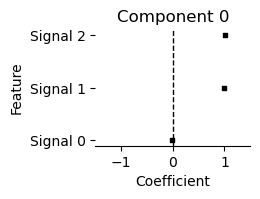

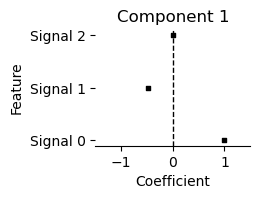

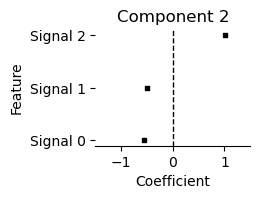

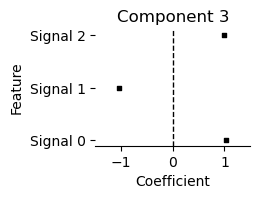

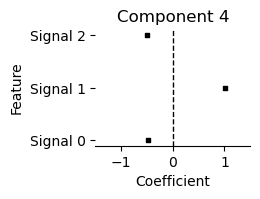

In [19]:
for i in range(model.n_components):
    ax = model.plot_coefficients(i, figsize = (2,1.5))
    ax.set(xlim = (-1.5,1.5))

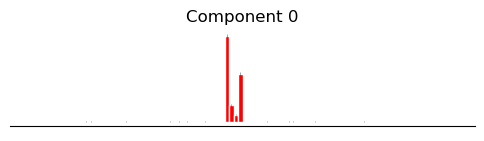

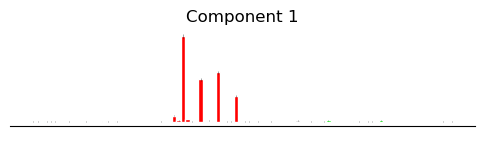

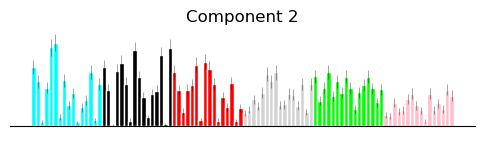

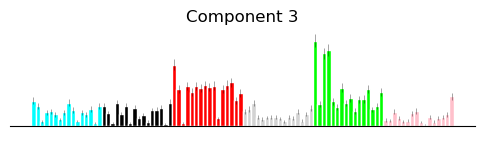

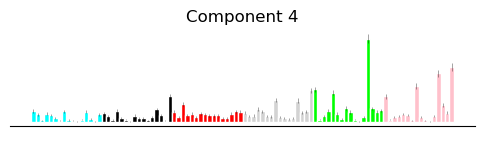

In [20]:
for i in range(model.n_components):
    model.plot_signature(i, normalization='local')